## Dependencies

In [1]:
import json, warnings, shutil, glob
from jigsaw_utility_scripts import *
from transformers import TFXLMRobertaModel, XLMRobertaConfig
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers, metrics, losses, layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

SEED = 0
seed_everything(SEED)
warnings.filterwarnings("ignore")

In [2]:
# Datasets
def get_training_dataset(x_train, y_train, batch_size, buffer_size):
    dataset = tf.data.Dataset.from_tensor_slices(({'input_ids': x_train[0], 
                                                   'attention_mask': x_train[1]}, y_train))
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048, seed=SEED)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(buffer_size)
    return dataset

def get_validation_dataset(x_valid, y_valid, batch_size, buffer_size):
    dataset = tf.data.Dataset.from_tensor_slices(({'input_ids': x_valid[0], 
                                                   'attention_mask': x_valid[1]}, y_valid))
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.cache()
    dataset = dataset.prefetch(buffer_size)
    return dataset

def get_test_dataset(x_test, batch_size, buffer_size):
    dataset = tf.data.Dataset.from_tensor_slices({'input_ids': x_test[0], 
                                                  'attention_mask': x_test[1]})
    dataset = dataset.batch(batch_size)
    return dataset

## TPU configuration

In [3]:
strategy, tpu = set_up_strategy()
print("REPLICAS: ", strategy.num_replicas_in_sync)
AUTO = tf.data.experimental.AUTOTUNE

# Mixed precision
tf.config.optimizer.set_experimental_options({"auto_mixed_precision": True})
# XLA
tf.config.optimizer.set_jit(True)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


# Load data

In [4]:
database_base_path = '/kaggle/input/jigsaw-dataset-split-pb-roberta-large-192-ratio-1/'
k_fold = pd.read_csv(database_base_path + '5-fold.csv')
valid_df = pd.read_csv("/kaggle/input/jigsaw-multilingual-toxic-comment-classification/validation.csv", usecols=['comment_text', 'toxic', 'lang'])

print('Train set samples: %d' % len(k_fold))
print('Validation set samples: %d' % len(valid_df))
display(k_fold.head())

# Unzip files
!tar -xvf /kaggle/input/jigsaw-dataset-split-pb-roberta-large-192-ratio-1/fold_1.tar.gz
# !tar -xvf /kaggle/input/jigsaw-dataset-split-pb-roberta-large-192-ratio-1/fold_2.tar.gz
# !tar -xvf /kaggle/input/jigsaw-dataset-split-pb-roberta-large-192-ratio-1/fold_3.tar.gz
# !tar -xvf /kaggle/input/jigsaw-dataset-split-pb-roberta-large-192-ratio-1/fold_4.tar.gz
# !tar -xvf /kaggle/input/jigsaw-dataset-split-pb-roberta-large-192-ratio-1/fold_5.tar.gz

Train set samples: 267220
Validation set samples: 8000


,index,comment_text,toxic,toxic_int,fold_1,fold_2,fold_3,fold_4,fold_5
0,894207,@Little Jimmy: I agree. I would also suggest t...,0.00000,0,train,train,validation,train,train
1,1681221,Well. There is already soft enforcement. Ho...,0.00000,0,train,train,validation,train,train
2,1320527,Great another mediocre season.,0.60000,1,train,train,validation,train,train
3,1521370,Putting your money where your mouth is. Can't...,0.65625,1,validation,train,train,train,train
4,922924,Despite the eloquence of your (non-)response (...,0.00000,0,train,train,train,train,validation


fold_1/
fold_1/y_valid.npy
fold_1/y_train.npy
fold_1/x_valid.npy
fold_1/x_train.npy


# Model parameters

In [5]:
base_path = '/kaggle/input/jigsaw-transformers/XLM-RoBERTa/'

config = {
  "MAX_LEN": 192,
  "BATCH_SIZE": 128,
  "EPOCHS": 5,
  "LEARNING_RATE": 1e-5, 
  "ES_PATIENCE": 1,
  "N_FOLDS": 1,
  "base_model_path": base_path + 'tf-xlm-roberta-large-tf_model.h5',
  "config_path": base_path + 'xlm-roberta-large-config.json'
}

with open('config.json', 'w') as json_file:
    json.dump(json.loads(json.dumps(config)), json_file)

# Model

In [6]:
module_config = XLMRobertaConfig.from_pretrained(config['config_path'], output_hidden_states=False)

def model_fn(MAX_LEN):
    input_ids = layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_ids')
    attention_mask = layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name='attention_mask')
    
    base_model = TFXLMRobertaModel.from_pretrained(config['base_model_path'], config=module_config)
    last_hidden_state, _= base_model({'input_ids': input_ids, 'attention_mask': attention_mask})
    
    cls_token = last_hidden_state[:, 0, :]
    
    output = layers.Dense(1, activation='sigmoid', dtype='float32', name='output')(cls_token)
    
    model = Model(inputs=[input_ids, attention_mask], outputs=output)
    model.compile(optimizers.Adam(lr=config['LEARNING_RATE']), 
                  loss=losses.BinaryCrossentropy(), 
                  metrics=[metrics.BinaryAccuracy(), metrics.AUC()])
    
    return model

# Train

In [7]:
history_list = []

for n_fold in range(config['N_FOLDS']):
    tf.tpu.experimental.initialize_tpu_system(tpu)
    print('\nFOLD: %d' % (n_fold+1))
    # Load data
    base_data_path = 'fold_%d/' % (n_fold+1)
    x_train = np.load(base_data_path + 'x_train.npy')
    y_train = np.load(base_data_path + 'y_train.npy').astype(np.float32)
    x_valid_ml = np.load(database_base_path + 'x_valid.npy')
    y_valid_ml = np.load(database_base_path + 'y_valid.npy').astype(np.float32)
    
    step_size = x_train.shape[1] // config['BATCH_SIZE']
    
    ### Delete data dir
    shutil.rmtree(base_data_path)

    # Train model
    model_path = 'model_fold_%d.h5' % (n_fold+1)
    es = EarlyStopping(monitor='val_loss', mode='min', patience=config['ES_PATIENCE'], 
                       restore_best_weights=True, verbose=1)
    checkpoint = ModelCheckpoint(model_path, monitor='val_loss', mode='min', 
                                 save_best_only=True, save_weights_only=True, verbose=1)
    
    with strategy.scope():
        model = model_fn(config['MAX_LEN'])
        
    history = model.fit(get_training_dataset(x_train, y_train, config['BATCH_SIZE'], AUTO),
                        validation_data=(get_validation_dataset(x_valid_ml, y_valid_ml, config['BATCH_SIZE'], AUTO)),
                        callbacks=[checkpoint, es],
                        epochs=config['EPOCHS'], 
                        steps_per_epoch=step_size,
                        verbose=2).history
        
    history_list.append(history)
    
    # Fine-tune on validation set
    print('\nFine-tune on validation set')
    n_steps2 = x_valid_ml.shape[1] // config['BATCH_SIZE']

    history2 = model.fit(get_training_dataset(x_valid_ml, y_valid_ml, config['BATCH_SIZE'], AUTO),
                         steps_per_epoch=n_steps2,
#                          epochs=config['EPOCHS'],
                         epochs=2,
                         verbose=2).history
    
    # Make predictions
#     train_preds = model.predict(get_test_dataset(np.load(base_data_path + 'x_train.npy'), config['BATCH_SIZE'], AUTO))
#     valid_preds = model.predict(get_test_dataset(np.load(base_data_path + 'x_valid.npy'), config['BATCH_SIZE'], AUTO))
#     valid_ml_preds = model.predict(get_test_dataset(np.load(database_base_path + 'x_valid.npy'), config['BATCH_SIZE'], AUTO))
    
#     k_fold.loc[k_fold['fold_%d' % (n_fold+1)] == 'train', 'pred_%d' % (n_fold+1)] = np.round(train_preds)
#     k_fold.loc[k_fold['fold_%d' % (n_fold+1)] == 'validation', 'pred_%d' % (n_fold+1)] = np.round(valid_preds)
#     valid_df['pred_%d' % (n_fold+1)] = np.round(valid_ml_preds)


FOLD: 1
Train for 1670 steps, validate for 62 steps
Epoch 1/5

Epoch 00001: val_loss improved from inf to 0.26788, saving model to model_fold_1.h5
1670/1670 - 877s - loss: 0.4270 - binary_accuracy: 0.4654 - auc: 0.9336 - val_loss: 0.2679 - val_binary_accuracy: 0.8616 - val_auc: 0.9073
Epoch 2/5

Epoch 00002: val_loss improved from 0.26788 to 0.25195, saving model to model_fold_1.h5
1670/1670 - 714s - loss: 0.3897 - binary_accuracy: 0.4768 - auc: 0.9539 - val_loss: 0.2520 - val_binary_accuracy: 0.8761 - val_auc: 0.9212
Epoch 3/5

Epoch 00003: val_loss did not improve from 0.25195
Restoring model weights from the end of the best epoch.
1670/1670 - 716s - loss: 0.3761 - binary_accuracy: 0.4809 - auc: 0.9600 - val_loss: 0.2728 - val_binary_accuracy: 0.8693 - val_auc: 0.9197
Epoch 00003: early stopping

Fine-tune on validation set
Train for 62 steps
Epoch 1/2
62/62 - 100s - loss: 0.2101 - binary_accuracy: 0.9032 - auc: 0.9426
Epoch 2/2
62/62 - 25s - loss: 0.1623 - binary_accuracy: 0.9278 -

## Model loss graph

Fold: 1


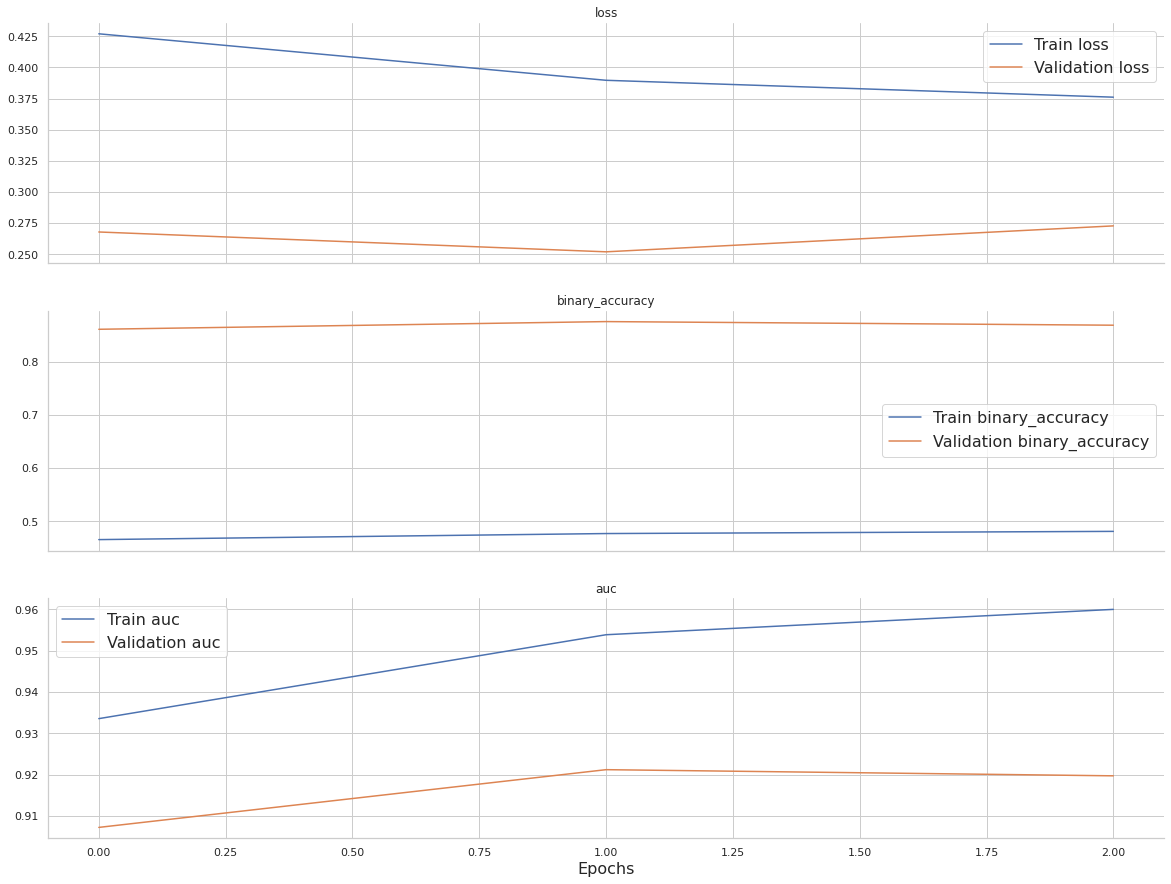

In [8]:
sns.set(style="whitegrid")
for n_fold in range(config['N_FOLDS']):
    print('Fold: %d' % (n_fold+1))
    plot_metrics(history_list[n_fold])

# Model evaluation

In [9]:
# display(evaluate_model(k_fold, config['N_FOLDS']).style.applymap(color_map))

# Confusion matrix

In [10]:
# for n_fold in range(config['N_FOLDS']):
#     print('Fold: %d' % (n_fold+1))
#     train_set = k_fold[k_fold['fold_%d' % (n_fold+1)] == 'train']
#     validation_set = k_fold[k_fold['fold_%d' % (n_fold+1)] == 'validation'] 
#     plot_confusion_matrix(train_set['toxic'], train_set['pred_%d' % (n_fold+1)], 
#                           validation_set['toxic'], validation_set['pred_%d' % (n_fold+1)])

# Model evaluation by language

In [11]:
# display(evaluate_model_lang(valid_df, config['N_FOLDS']).style.applymap(color_map))

# Visualize predictions

In [12]:
pd.set_option('max_colwidth', 120)
print('English validation set')
display(k_fold[['comment_text', 'toxic'] + [c for c in k_fold.columns if c.startswith('pred')]].head(10))

print('Multilingual validation set')
display(valid_df[['comment_text', 'toxic'] + [c for c in k_fold.columns if c.startswith('pred')]].head(10))

English validation set


,comment_text,toxic
0,@Little Jimmy: I agree. I would also suggest that shareholder expectations about returns are sometimes what give the...,0.00000
1,Well. There is already soft enforcement. How many places won't let you comment without Facebook?,0.00000
2,Great another mediocre season.,0.60000
3,"Putting your money where your mouth is. Can't fault him for that, for sure. Oh, wait, that's right, he had no prob...",0.65625
4,"Despite the eloquence of your (non-)response (he said, sarcastically), a large and growing majority of Americans thi...",0.00000
5,Are you saying the majority of people in cities across the country with rail transit want their systems shut down? C...,0.00000
6,What about Junior's vacation investigation; Morneau and his conflicts of interest; Junior's and Morneau's hidden mo...,0.60000
7,Here's a great article that describes what happened in Chicago when they sold their parking authority to a Wall Stre...,0.20000
8,"scuppers.. Facts and reality won't help your case. You'll need to get into the gutter with false facts, false accusa...",1.00000
9,Clearly those people haven't seen the latest Jack Reacher movie for proper instructions on beating up on bad guys.\n...,0.00000


Multilingual validation set


,comment_text,toxic
0,Este usuario ni siquiera llega al rango de hereje . Por lo tanto debería ser quemado en la barbacoa para purifi...,0
1,"Il testo di questa voce pare esser scopiazzato direttamente da qui. Immagino possano esserci problemi di copyright, ...",0
2,"Vale. Sólo expongo mi pasado. Todo tiempo pasado fue mejor, ni mucho menos, yo no quisiera retroceder 31 años a nive...",1
3,Bu maddenin alt başlığı olarak uluslararası ilişkiler ile konuyu sürdürmek ile ilgili tereddütlerim var.Önerim siy...,0
4,Belçika nın şehirlerinin yanında ilçe ve beldelerini yaparken sanırım Portekizi örnek alacaksın. Ben de uzak gelecek...,0
5,"güzel, zaten kaynaklandırması zor subjektif kategoriler bunlar. bazı maddelerden çıkartmak, kiminden çıkartıp kimind...",0
6,"No es mala idea. De hecho, yo estaba pensando descolgarme ya del reto mensual, pero esto vuelve a ilusionarme. El pr...",0
7,"Kod hatalarını düzeltmişsiniz,elinize sağlık çok teşekkürler.Önceki sürümleri araştırdım.13 Haziran 2010 da Kullanıc...",0
8,Levent Abi nasılsın? Hayat nasıl gidiyor? Umarım her şey istediğin gibidir. Bu arada Janet Jackson maddesi seçkin ma...,0
9,"Creo que es importante que podamos reconocer a gente como Victor Manuel Vucetich , quien es originario de Tampico y ...",0


# Test set predictions

In [13]:
model_path_list = glob.glob('/kaggle/working/' + '*.h5')
model_path_list.sort()
print('Models to predict:')
print(*model_path_list, sep = "\n")

Models to predict:
/kaggle/working/model_fold_1.h5


In [14]:
x_test = np.load(database_base_path + 'x_test.npy')
NUM_TEST_IMAGES = x_test.shape[1]
test_preds = np.zeros((NUM_TEST_IMAGES, 1))

for model_path in model_path_list:
    tf.tpu.experimental.initialize_tpu_system(tpu)
    print(model_path)
    with strategy.scope():
        model = model_fn(config['MAX_LEN'])
        model.load_weights(model_path)

    test_preds += model.predict(get_test_dataset(x_test, config['BATCH_SIZE'], AUTO)) / len(model_path_list)

/kaggle/working/model_fold_1.h5


In [15]:
submission = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/sample_submission.csv')
submission['toxic'] = test_preds
submission.to_csv('submission.csv', index=False)

display(submission.describe())
display(submission.head(10))

,id,toxic
count,63812.000000,63812.000000
mean,31905.500000,0.207816
std,18421.082026,0.290046
min,0.000000,0.000070
25%,15952.750000,0.001595
50%,31905.500000,0.014200
75%,47858.250000,0.410151
max,63811.000000,0.999647


,id,toxic
0,0,0.000515
1,1,0.003358
2,2,0.235208
3,3,0.000659
4,4,0.000912
5,5,0.015108
6,6,0.000462
7,7,0.018682
8,8,0.783634
9,9,0.133691
